In [2]:
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd 
from Tools import *

In [3]:
def Sim0D_test(t_gas,gas_eq,fuel1,fuel2,oxidizer,case,dt,tmax,tol=0.1):
    
    print(case)
    pressure, temperature, equivalence_ratio,mixture = case

    fuel_mix = f'{fuel1}:{mixture}, {fuel2}:{1-mixture}'
    t_gas.set_equivalence_ratio(equivalence_ratio,fuel_mix,oxidizer)
    t_gas.TP = temperature,pressure
    
    r = ct.IdealGasConstPressureReactor(t_gas)
    sim = ct.ReactorNet([r])
    # sim.max_steps=100000
    t_list = [0]
    temp_list = [t_gas.T]
    y_list = []
    y_list.append(r.Y)
    
    n_iter = 0 
    time = 0
    equil_bool = False 
    
    gas_eq.TP = temperature,pressure
    gas_eq.set_equivalence_ratio(equivalence_ratio,fuel_mix,oxidizer)
    gas_eq.equilibrate("HP")
    state_equil = np.append(gas_eq.X, gas_eq.T)
    
    while time <tmax:
        time +=dt
        sim.advance(time)
        # time = sim.step()
        t_list.append(time)
        temp_list.append(r.T)
        y_list.append(r.Y)
        state_current = np.append(r.thermo.X, r.T)
        residual = (
            100
            * np.linalg.norm(state_equil - state_current, ord=np.inf)
            / np.linalg.norm(state_equil, ord=np.inf)
        )
        n_iter +=1 
        # print(residual)
        # if residual < tol :  #if time >= tmax :
        #     return t_list, temp_list, np.array(y_list)
        if len(temp_list) > 300 : 
            if np.abs(temp_list[-1]  - temp_list[-2]) < 1e-8 :
                return t_list, temp_list, np.array(y_list)
    
    return t_list, temp_list, np.array(y_list)

In [4]:
gas_det = ct.Solution("detailed.yaml")
gas_det2 = ct.Solution("detailed.yaml")
gas_red = ct.Solution("reduced.yaml")
gas_red2 = ct.Solution("reduced.yaml")
gas_optim = ct.Solution("./Start_mpi_pop10_gen100_PyOptMECH_Case1/Reduced_mpi_pop_PyOptMECH.yaml")
gas_optim2 = ct.Solution("./Start_mpi_pop10_gen100_PyOptMECH_Case1/Reduced_mpi_pop_PyOptMECH.yaml")
fuel1 = "NH3"
fuel2 = "H2"
pressure = np.linspace(1,1,1).tolist()
temperature = np.linspace(1500,1500,1).tolist()
phi = np.linspace(1,1,1).tolist()
mixture =np.linspace(0.85,0.85,1).tolist()
case = generate_test_cases_bifuel(temperature,pressure,phi,mixture)
dt = 1e-6 
tmax = 1 
oxidizer = 'O2:0.21, N2:0.79, AR : 0.01'

Targets = ["H2", "NH3", "O2", "OH","NO", 'H2O','NO2', 'N2O','N2']
Non_Target = ['H', 'O', 'HO2', 'N', 'N2H3', 'N2H2', 'HNO',"NH","NH2","NNH"]
idx_target_ref = spcs_name_idx(gas_det,Targets)
idx_target_red = spcs_name_idx(gas_red,Targets)
idx_target_optim = spcs_name_idx(gas_optim,Targets)

idx_non_target_ref = spcs_name_idx(gas_det,Non_Target)
idx_non_target_red = spcs_name_idx(gas_red,Non_Target)
idx_non_target_optim = spcs_name_idx(gas_optim,Non_Target)

Time_ref_list =[] 
Temp_ref_list=[]
Y_ref_list =[]
Y_nt_ref_list =[]

Time_red_list =[] 
Temp_red_list=[]
Y_red_list =[]
Y_nt_red_list=[]

Time_optim_list =[] 
Temp_optim_list=[]
Y_optim_list =[]
Y_nt_optim_list=[]

for c in case  :
    Time_ref, Temp_ref,Y_ref = Sim0D_test(gas_det,gas_det2,fuel1,fuel2,oxidizer,c,dt,tmax,tol= 0.1)
    Time_red, Temp_red,Y_red = Sim0D_test(gas_red,gas_red2,fuel1,fuel2,oxidizer,c,dt,tmax,tol=0.1)
    Time_optim, Temp_optim,Y_optim = Sim0D_test(gas_optim,gas_optim2,fuel1,fuel2,oxidizer,c,dt,tmax,tol=0.1)
    
    Time_ref_list.append(Time_ref)
    Temp_ref_list.append(Temp_ref)
    Y_ref_list.append(Y_ref[:,np.array(idx_target_ref)])
    Y_nt_ref_list.append(Y_ref[:,np.array(idx_non_target_ref)])
    
    Time_red_list.append(Time_red)
    Temp_red_list.append(Temp_red)
    Y_red_list.append(Y_red[:,np.array(idx_target_red)])
    Y_nt_red_list.append(Y_red[:,np.array(idx_non_target_red)])
    
    Time_optim_list.append(Time_optim)
    Temp_optim_list.append(Temp_optim)
    Y_optim_list.append(Y_optim[:,np.array(idx_target_optim)])
    Y_nt_optim_list.append(Y_optim[:,np.array(idx_non_target_optim)])

/tmp/ipykernel_577140/3961820569.py:1: UserWarning: NasaPoly2::validate: 
For species OHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.62056162666667
	Value computed using high-temperature polynomial: 53.5841554314

  gas_det = ct.Solution("detailed.yaml")
/tmp/ipykernel_577140/3961820569.py:2: UserWarning: NasaPoly2::validate: 
For species OHV, discontinuity in h/RT detected at Tmid = 1000
	Value computed using low-temperature polynomial:  53.62056162666667
	Value computed using high-temperature polynomial: 53.5841554314

  gas_det2 = ct.Solution("detailed.yaml")


(101325.0, 1500.0, 1.0, 0.85)
(101325.0, 1500.0, 1.0, 0.85)
(101325.0, 1500.0, 1.0, 0.85)


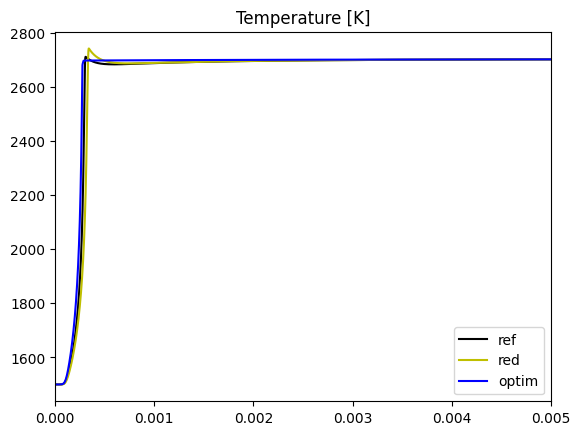

In [17]:
plt.figure(1)
plt.plot(Time_ref_list[0],Temp_ref_list[0],'k',label="ref")
plt.plot(Time_red_list[0],Temp_red_list[0],'y',label="red")
plt.plot(Time_optim_list[0],Temp_optim_list[0],'b',label="optim")
plt.title("Temperature [K]")
plt.xlim([0,0.005])

plt.legend()
plt.savefig("temperature.png")

In [6]:
def new_ai (time,temp,case) : 
    output = [] 
    for c in range(len(case)) : 
        loc_time = time[c]
        loc_temp = temp[c]
        diff_temp = np.diff(loc_temp)/np.diff(loc_time)
        ign_pos = np.argmax(diff_temp)
        output.append(loc_time[ign_pos])
    return output

In [7]:
ai_ref = new_ai(Time_ref_list,Temp_ref_list,case)
ai_red = new_ai(Time_red_list,Temp_red_list,case)
ai_optim = new_ai(Time_optim_list,Temp_optim_list,case)
print(f"ai_ref = {ai_ref}")
print(f"ai_red = {ai_red}")
print(f"ai_optim = {ai_optim}")


ai_ref = [0.00029400000000000064]
ai_red = [0.0003250000000000014]
ai_optim = [0.00027300000000000013]


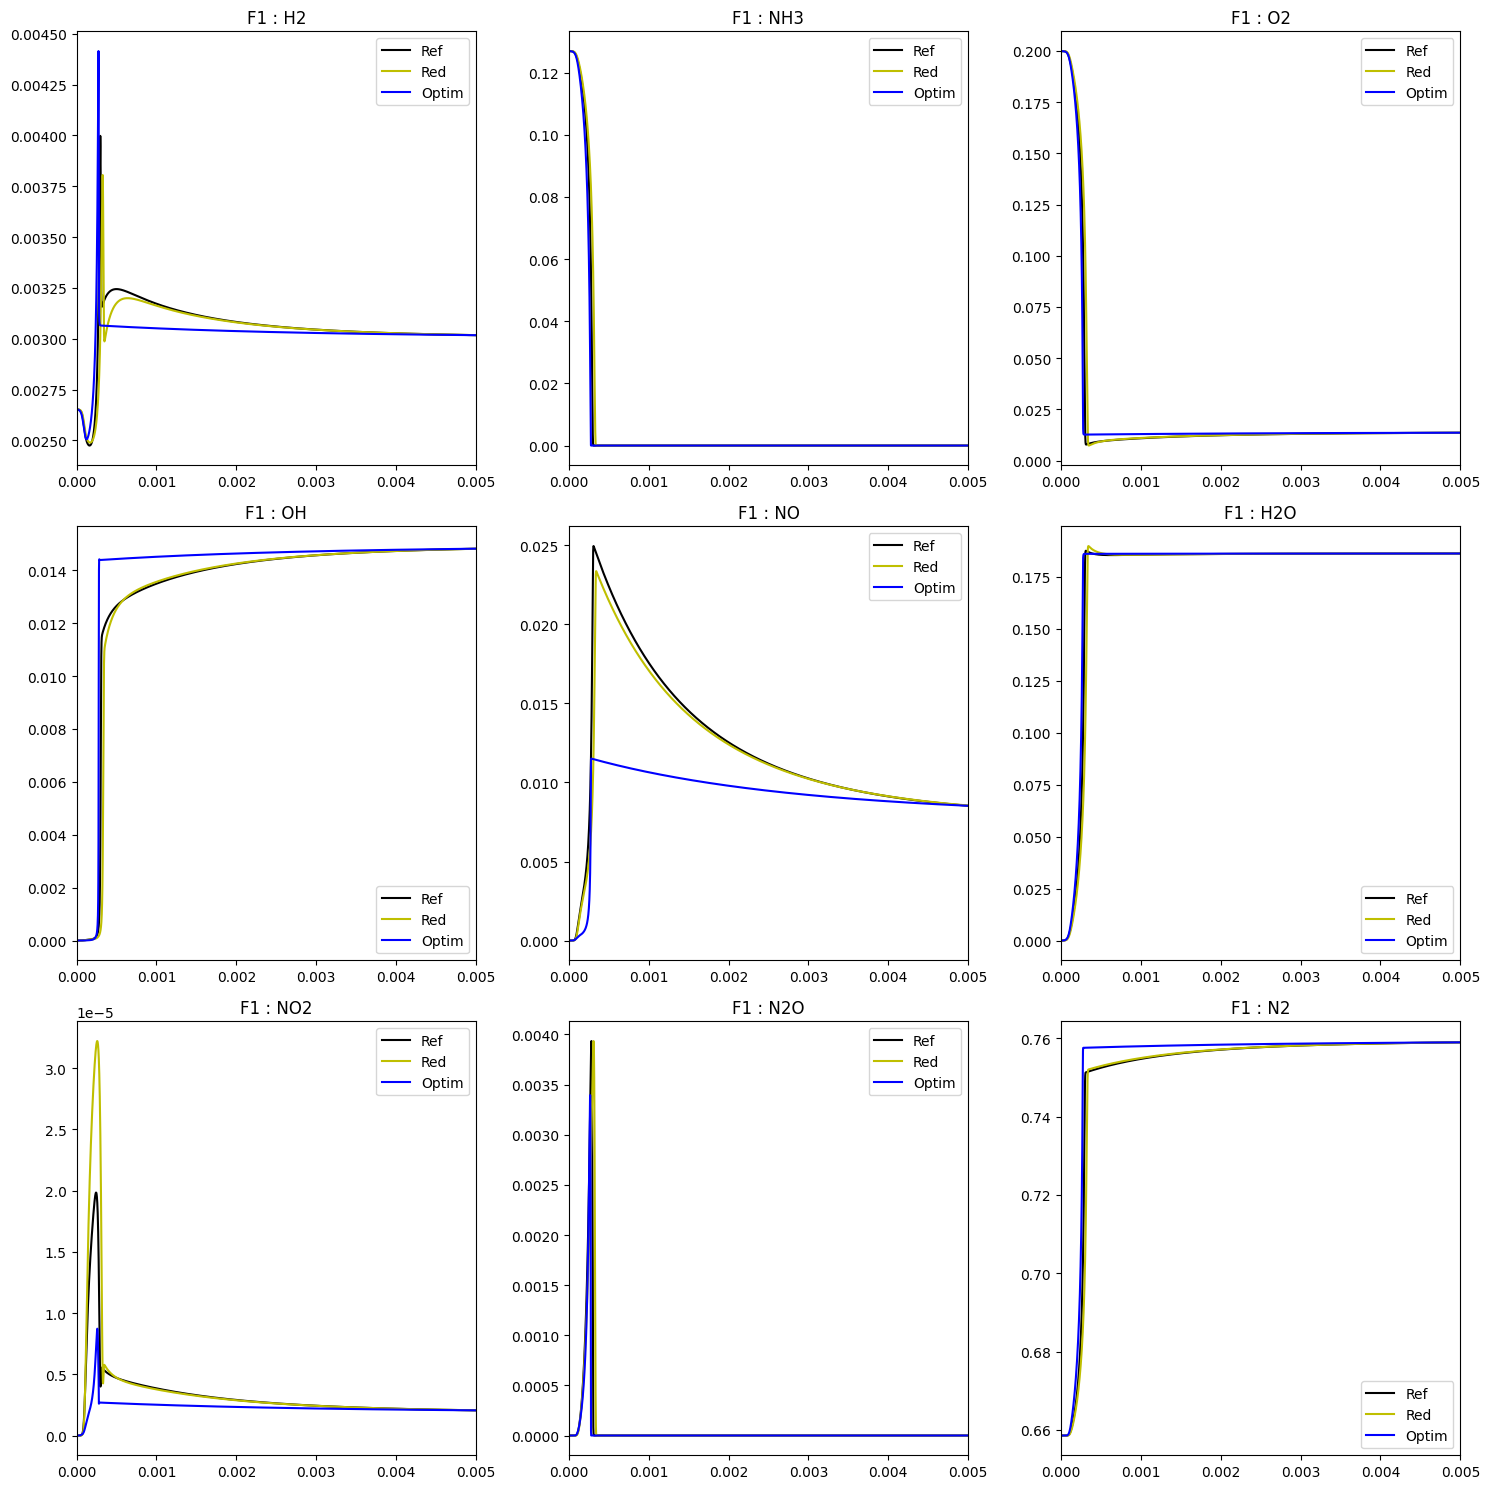

In [15]:
# Nombre de sous-graphiques (subplots)
n = len(Targets)
cols = 3  # Nombre de colonnes de subplots
rows = (n // cols) + (n % cols > 0)  # Nombre de lignes, arrondi vers le haut

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Taille ajustable
axes = axes.flatten()  # Transformer la matrice d'axes en liste pour faciliter l'indexation

for i in range(n):
    ax = axes[i]
    ax.plot(Time_ref_list[0], Y_ref_list[0][:, i], 'k', label="Ref")
    ax.plot(Time_red_list[0], Y_red_list[0][:, i],'y', label="Red")
    ax.plot(Time_optim_list[0], Y_optim_list[0][:, i],'b', label="Optim")
    ax.set_xlim([0, 0.005])
    ax.set_title(f"F1 : {Targets[i]}")
    ax.legend()

# Supprimer les subplots vides si len(Targets) < rows * cols
for i in range(n, rows * cols):
    fig.delaxes(axes[i])

plt.tight_layout()  # Ajuster l'espacement pour éviter les chevauchements
plt.savefig("Targets.png")
plt.show()


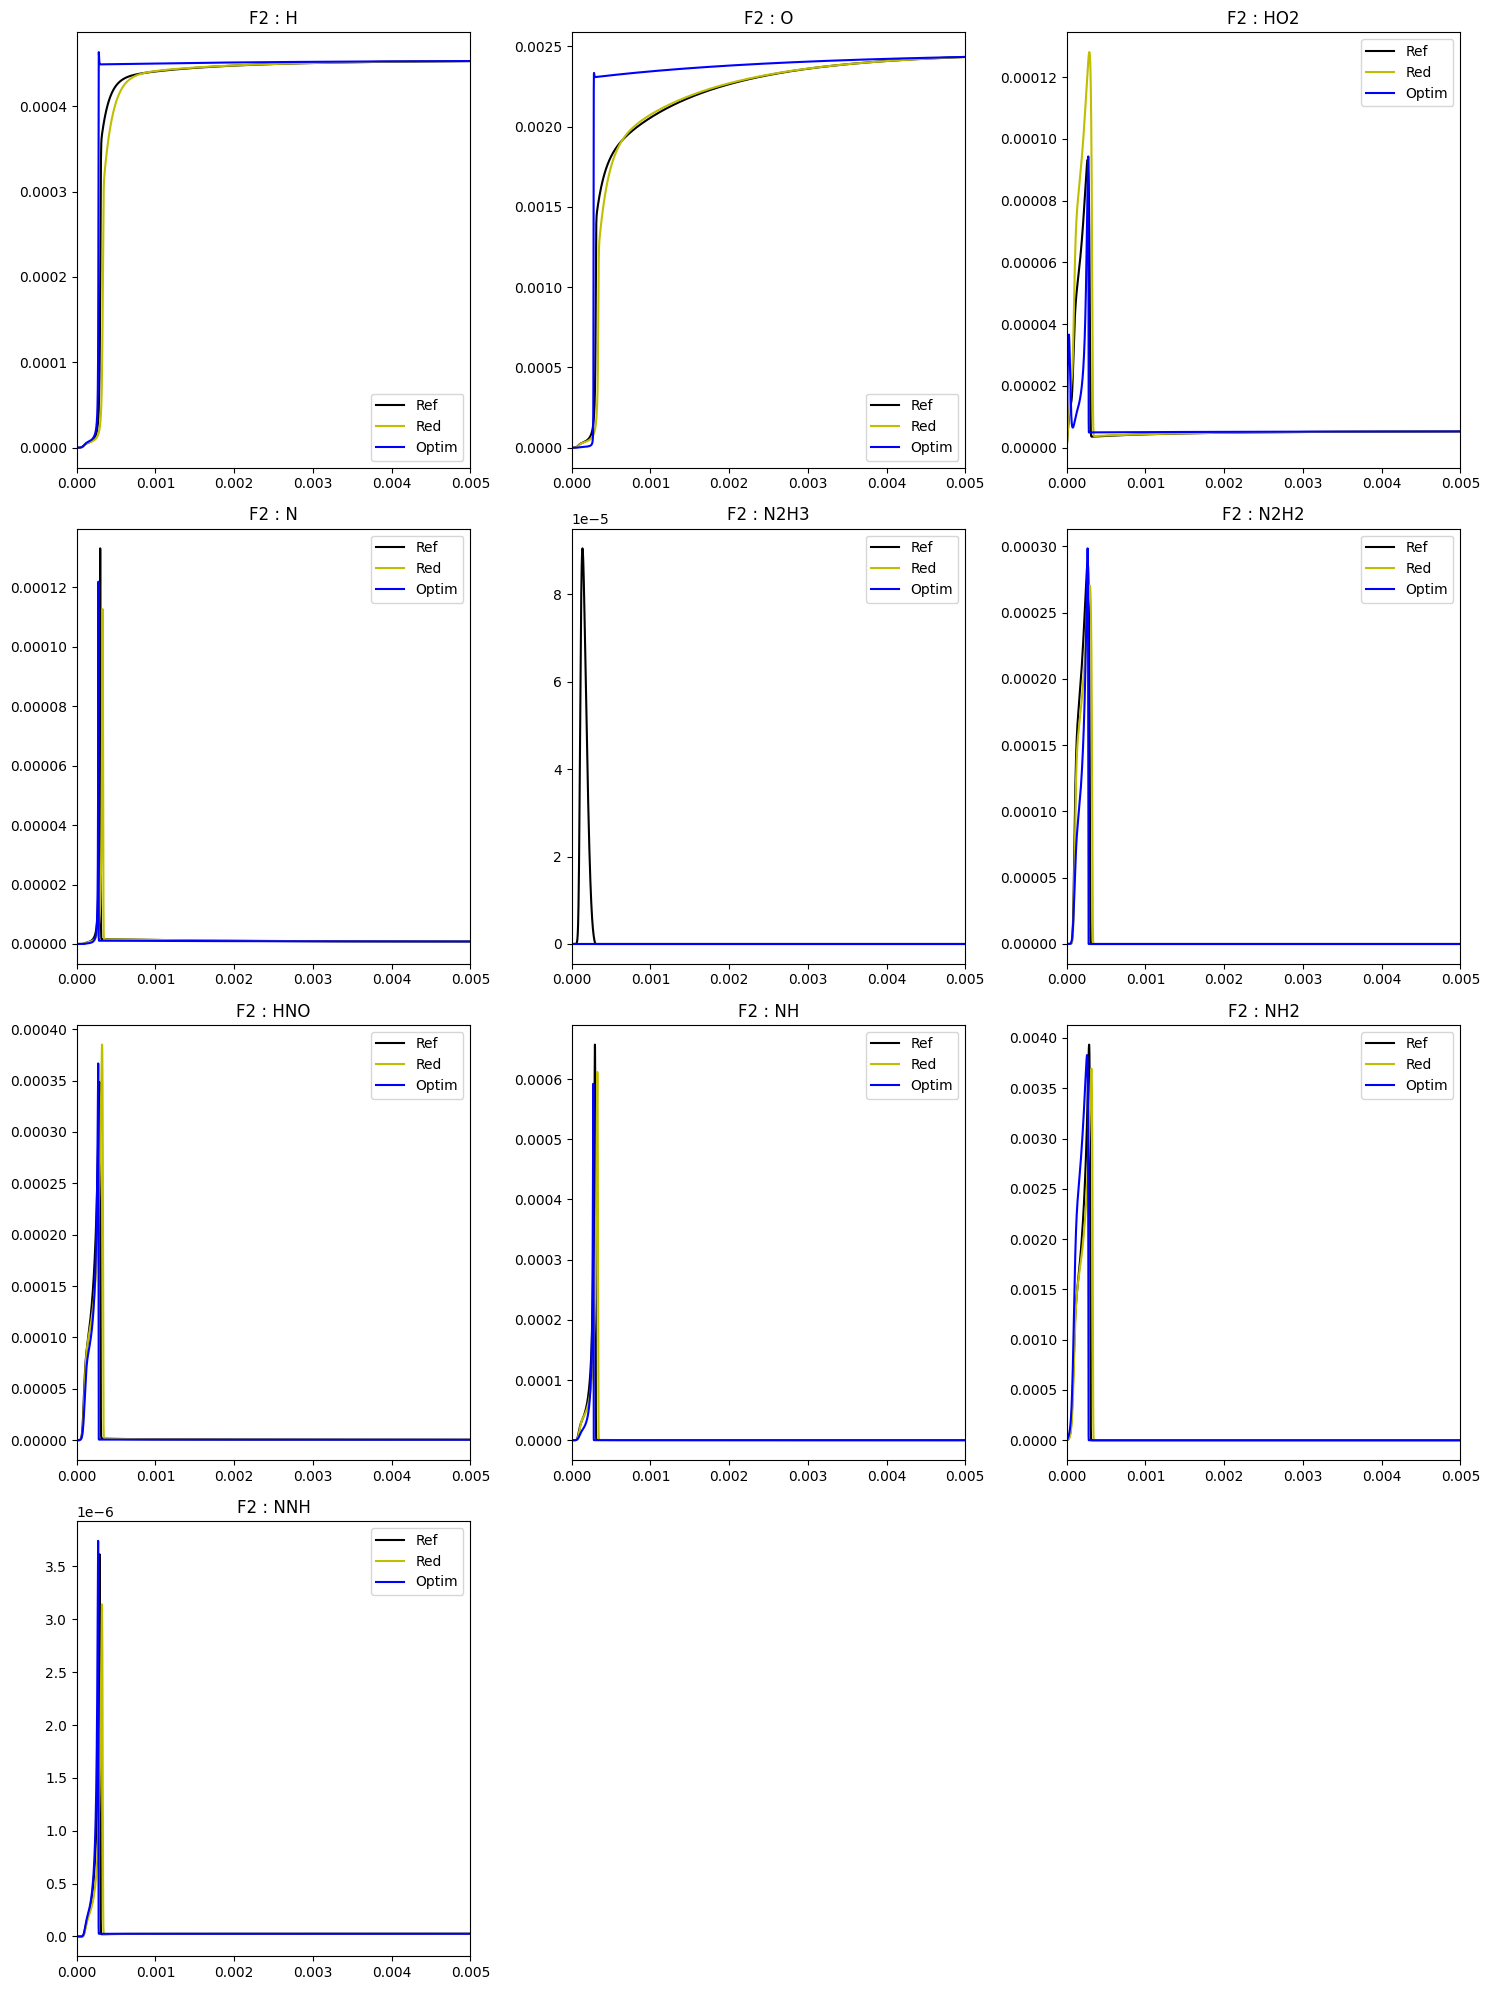

In [16]:
# Définition du nombre de sous-graphiques (par exemple, en grille)
n = len(Non_Target)
cols = 3  # Nombre de colonnes de subplots
rows = (n // cols) + (n % cols > 0)  # Nombre de lignes, arrondi vers le haut

fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))  # Ajuste la taille selon tes besoins
axes = axes.flatten()  # Aplatir la matrice d'axes pour faciliter l'indexation

for j in range(n):
    ax = axes[j]
    ax.plot(Time_ref_list[0], Y_nt_ref_list[0][:, j],'k', label="Ref")
    ax.plot(Time_red_list[0], Y_nt_red_list[0][:, j],'y', label="Red")
    ax.plot(Time_optim_list[0], Y_nt_optim_list[0][:, j],'b', label="Optim")
    ax.set_xlim([0, 0.005])
    ax.set_title(f"F2 : {Non_Target[j]}")
    ax.legend()

# Supprimer les sous-graphiques vides si len(Non_Target) < rows * cols
for j in range(n, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()  # Ajuster l'espacement pour éviter les chevauchements
plt.savefig("Non_Target.png")
plt.show()
